**02452** *Machine Learning*, Technical University of Denmark

- This Jupyter notebook contains exercises where you fill in missing code related to the lecture topic. *First*, try solving each task yourself. *Then* use the provided solution (an HTML file you can open in any web browser) as inspiration if needed. If you get stuck, ask a TA for help.

- Some tasks may be difficult or time-consuming - using the solution file or TA support is expected and perfectly fine, as long as you stay active and reflect on the solution.

- You are not expected to finish everything during the session. Prepare by looking at the exercises *before* the class, consult the TAs *during* class, and complete the remaining parts *at home*.

---

# Week 3: Computational Linear Algebra and Principal Component Analysis

**Content:**
- Part 1: Understanding the basics of PCA
- Part 2: PCA on the NanoNose dataset
- Part 3: Hidden structure in handwritten digits
- Part 4: $k$-nearest neighbors on reduced data

**Objectives:**
- Get acquainted with how data can be filtered and visualized using principal component analysis (PCA).
- Can apply and interpret principal component analysis (PCA) for data visualization and dimensionality reduction / feature extraction.
- Understand and apply matrix operations on data matrices with Python.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

## Introduction

Data in the real world is typically **high-dimensional**, containing many collected attributes - as examples, you have already worked with images and the wine dataset. According to the **[manifold hypothesis](https://en.wikipedia.org/wiki/Manifold_hypothesis?utm_source=chatgpt.com)**, much of this data actually lies on a lower-dimensional manifold, meaning that the data can be explained in fewer dimensions - i.e. there is an **underlying structure that can be described with fewer dimensions**. Exploiting this structure allows us to remove redundant information in the data which in turn can help reduce computational and storage requirements as well as make high-dimensional data easier to visualize and interpret.

Using basic linear algebra, we can project data from its original high-dimensional space into a **lower-dimensional subspace**. The central question then becomes: what projection best preserves the structure of the data? In this week’s exercise, we explore one of the most widely used approaches to answering this question, namely Principal Component Analysis (PCA).

## Part 1: Understanding the basics of PCA

In this exercise, we will build intuition for PCA by constructing a simple toy example, recreating the PCA example of a Gaussian point cloud from the lecture slides. 

For intuition, we first generate a "high"-dimensional dataset that lie in a lower-dimensional space by:
1) generating $N=1000$ samples in $\mathbb{R}^2$ from a multivariate Gaussian distribution (more on that next week!). We store these points as $\boldsymbol{Z}$ of shape $N \times K$.
2) embedding these points linearly in $\mathbb{R}^3$. We store the embedded points in our well-known data matrix $\boldsymbol{X}$ of shape $N \times M$. 

We provide the code and visualize the point cloud in the cell below.


**Task 1.1:** Verify that the points in $\mathbb{R}^3$ actually lie on a 2-dimensional plane.

> *Hint:* Remember that you can add the magic `%matplotlib qt` in the beginning of the cell to open the plot in a separate window where you can interact with the 3D element. Remember to also revert to `%matplotlib inline` when done.

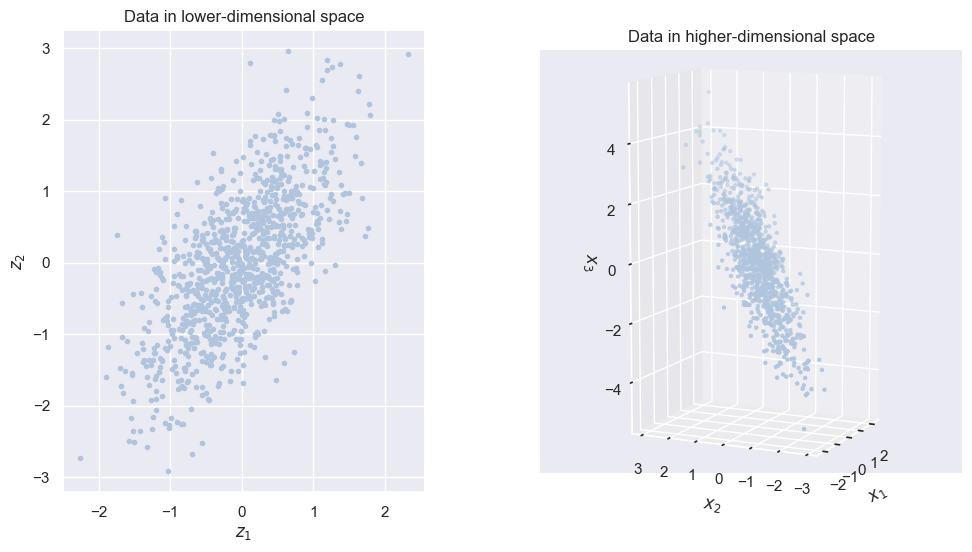

In [4]:
%matplotlib inline

N = 1000
M = 3
K = 2

np.random.seed(42)

# Define the mean and covariance matrix for the 2D Gaussian
mu = np.array([0, 0])
Sigma = np.array([[0.5, 0.5], [0.5, 1.0]])

# Sample points from the 2D Gaussian
Z = np.random.multivariate_normal(mu, Sigma, N)

# Embed the points in the higher-dimensional space
X = np.hstack((Z, (Z[:, 0] + Z[:, 1])[:, np.newaxis])) # Add a third dimension as a linear combination of the first two

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.set_title('Data in lower-dimensional space')
ax.scatter(Z[:, 0], Z[:, 1], c='lightsteelblue', marker='.')
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_aspect('equal')

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=10, azim=-155)
ax.set_title('Data in higher-dimensional space')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='lightsteelblue', marker='.')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
ax.set_aspect('equal')
plt.show()

PCA is a linear projection technique for reducing dimensionality by finding the directions (principal components) along which the data exhibits the **greatest variance**, thereby **maximizing separation** between points in the projected subspace. As seen in the lecture, identifying these principal components $\left[\boldsymbol{v}_1, \boldsymbol{v}_2, \dots, \boldsymbol{v}_M\right]$ reduces to solving an eigenvalue problem that optimizes for maximal variance:
$$
    \underset{\boldsymbol{v}}{\arg \max} \ \text{Var}[\boldsymbol{X} \boldsymbol{v}] \quad\text{s.t.}\quad \lVert\boldsymbol{v}\rVert^2 = 1 \qquad \Rightarrow \qquad
    \frac{1}{N-1} \tilde{\boldsymbol{X}}^\top \tilde{\boldsymbol{X}} \boldsymbol{v}_i = \lambda \boldsymbol{v}_i
$$ 
where $\tilde{\boldsymbol{X}} = \boldsymbol{X} - \boldsymbol{\mu}$ is the centered data (i.e. it has zero mean) and hence $\hat{\boldsymbol{S}}=\frac{1}{N-1} \tilde{\boldsymbol{X}}^\top \tilde{\boldsymbol{X}}$ is the estimated correlation matrix of the data. We can therefore find the PCs as the eigenvectors of $\hat{\boldsymbol{S}}$ which we do efficiently using singular value decomposition (SVD) on the zero-mean data matrix, i.e. $\tilde{\boldsymbol{X}} = \boldsymbol{U} \boldsymbol{\Sigma} \boldsymbol{V}^T$, resulting in:
$$
    \boldsymbol{V}_M = \begin{bmatrix} | & | & & | \\ \boldsymbol{v}_1 & \boldsymbol{v}_2 & \dots & \boldsymbol{v}_M \\ | & | & & | \end{bmatrix} \qquad \text{and} \qquad \boldsymbol{\Sigma} = \begin{bmatrix} \sigma_1 & 0 & \dots & 0 \\ 0 & \sigma_2 & \dots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \dots & \sigma_M\end{bmatrix}
$$
where $\sigma_i$ is the $i$'th singular value. Using this, we can find out how much of the variation in the data each PCA component accounts for by computing the eigenvalue. We call this the **explained variance** and compute it as
$$
    \lambda_i = \frac{1}{(N-1)} \sigma^2_{i}
$$
Similarly, the fraction of explained variance for the $i$'th component is
$$
  \rho_i = \frac{\lambda_i}{\sum_{j=1}^M \lambda_j} = \frac{\frac{1}{(N-1)} \sigma^2_{i}}{\sum_{j=1}^M \frac{1}{(N-1)} \sigma^2_{i}} = \frac{\sigma_i^2}{\sum_{j=1}^M \sigma_j^2}
$$
i.e. the squared singular value of the given component divided by the sum of all the squared singular values. This equation is critical to understanding PCA and we encouge you to study it closer in the lecture notes in Chapter 3.

Lastly, remember that projections $\boldsymbol{b}_i$ and reconstructions $\hat{\boldsymbol{x}}_i$ can be computed for a collection of data points as:
$$
    \boldsymbol{B} = \tilde{\boldsymbol{X}} \boldsymbol{V}_{K} \quad \text{and} \quad \hat{\boldsymbol{X}} = \boldsymbol{V}_K \boldsymbol{B}
$$


As you can see, PCA only considers finding structure in observed data without knowing any target attribute and is therefore an **unsupervised learning** technique.

**Task 1.2:** Compute the PCA of the example above. Project the observations $\boldsymbol{X}$ to a lower dimensional subspace using $\boldsymbol{V}_K$ where $K=2$ and plot them as a scatter plot. Plot the $K=2$ principle components / directions on top of 1) the 3D point cloud and 2) the projected data.

> *Hint:* Use `sklearn.decomposition.PCA` to compute the PCA. Checkout the documentation for fitting and transforming/projecting with the PCA, use `fit_transform`

> *Hint:* Extract the principal components, i.e. $\boldsymbol{V}$, with the `components_` attribute of the PCA class. Are they the correct shape? We want each PC to be a column.

> *Hint:* Simply plot the PCs as lines using `plt.plot()`.

In [ ]:
# Create PCA object
pca = PCA(n_components=M)

# Fit and transform the data to get B
# Get the principal components, V_K
# YOUR CODE HERE
raise NotImplementedError()

# Define colors for the principal components
colors = ['red', 'darkgreen', 'orange']

# Create figure and subplot for high-dimensional data
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection='3d')
ax.set_title('Data in higher-dimensional space')
ax.view_init(elev=10, azim=-155) # viewing parameters

# Plot the high dimensional data, X - and the principal components, V_K, as lines. 
# YOUR CODE HERE
raise NotImplementedError()

# Figure layout
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$z$')
ax.set_aspect('equal')
ax.legend()

# Create subplot for projected data
ax = fig.add_subplot(122)
ax.set_title('Data projected to lower-dimensional space')

# Plot the projected data, B, in 2D - along with the principal components in the projected space (which are just the standard basis vectors in 2D).
# YOUR CODE HERE
raise NotImplementedError()

# Figure layout
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_aspect('equal')
ax.legend()

plt.tight_layout()
plt.show()

**Task 1.3:** Compute the explained variance and the fraction of explained variance for all $M=3$ components. Make two plots showing 1) a bar plot of explained variance per component and 2) the accumulated fraction of explained variance when increasing the number of principle components.

> *Hint:* Use the method `.explained_variance_` to get the explained variance per component.

> *Hint:* Use the method `.explained_variance_ratio` to get the fraction of explained variance per component.

> *Hint:* Use `np.cumsum()` to accumulate values of a numpy array.

In [ ]:
# Explained variance plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].set_title('Explained Variance')
axs[0].set_xlabel('Principal Components')
axs[0].set_ylabel('Explained Variance')

# Bar plot for explained variance
# YOUR CODE HERE
raise NotImplementedError()

# Accumulated explained variance plot
axs[1].set_title('Accumulated fraction of explained variance')
axs[1].set_xlabel('Principal Components')
axs[1].set_ylabel('Accumulated Explained Variance')

# Line plot for accumulated explained variance
# YOUR CODE HERE
raise NotImplementedError()
plt.show()

As you will be able to tell from the plot, the first two principal components are able to explain **ALL** the variance of our 3-dimensional data.

**Task 1.4:** Using the explained variance figures, argue how we can see that all the observed data from $\mathbb{R}^3$ lie on a lower-dimensional subspace in $\mathbb{R}^2$.

- *Answer:*


---
## Part 2: PCA on the NanoNose dataset

As an example dataset we will consider chemical sensor data obtained from the NanoNose project. The data contains 8 sensors named by the letters $A$-$H$ measuring different levels of concentration of Water, Ethanol, Acetone, Heptane and Pentanol injected into a small gas chamber. The data will be represented in matrix form such that each row contains the 8 sensors measurements (i.e. sensor $A$-$H$) of the various compounds injected into the gas chamber.


**Task 2.1:** Inspect the `nanonose.xls` file from the associated data folder and consider potential issues to be aware of when loading the file. Load the data and construct a data matrix $\boldsymbol{X}$ containing attributes $A$-$H$ as well as a descriptive target attribute $\boldsymbol{y}$ containing the fluid type as numerical values.

> *Hint:* Use `pd.read_excel()` to load `.xls`-files.

> *Hint:* Use indexing to choose the correct rows/columns when constructing $\boldsymbol{X}$ and $\boldsymbol{y}$.

> *Hint:* Use `sklearn.preprocessing.LabelEncoder` to easily construct $\boldsymbol{y}$ as a numerical array. This can be done by defining `label_encoder = LabelEncoder()` and mapping the target with `y = label_encoder.fit_transform(df.loc[1:, "Nanonose"])`.


In [ ]:
# Load the NanoNose dataset into X and y
# YOUR CODE HERE
raise NotImplementedError()

# Check the data shape
assert X.shape == (90, 8), "There should be 90 samples and 8 features"
assert y.shape == (90,), "There should be 90 samples in the target variable"

The data resides in an 8-dimensional space where each dimension corresponds to each of the 8 NanoNose sensors. This makes visualization of the raw data difficult, because it is difficult to plot data in more than 2-3 dimensions.

**Task 2.2:**  Plot the two attributes $A$ and $B$ against each other in a scatter plot and color by the liquid type, `y`. What do you see? Try to change the dimensions that are plotted against each other.

> *Hint:* Remember that you can use the inherent plotting functionalities of Pandas dataframes! `X.plot`

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

**Task 2.3:** Compute the PCA of the NanoNose data and plot the percent of variance explained by the principal components as well as the cumulative percentage of variance explained. 

> Can you verify that more than $90\%$ of the variation in the data is explained by the first 3 principal components? How many components would be needed for 95%?

In [ ]:
# Create PCA object and fit to the data
# Extract the principal components, V, and the variance explained ratio, rho
# YOUR CODE HERE
raise NotImplementedError()

# 90% threshold for variance explained
threshold = 0.9

# Plot variance explained
plt.figure()
plt.plot(range(1, len(rho) + 1), rho, "x-")
plt.plot(range(1, len(rho) + 1), np.cumsum(rho), "o-")
plt.plot([1, len(rho)], [threshold, threshold], "k--")
plt.title("Variance explained by principal components")
plt.xlabel("Principal component")
plt.ylabel("Variance explained")
plt.legend(["Individual", "Cumulative", "Threshold"])
plt.grid()
plt.show()

**Task 2.4** Project the data onto principal component 1 and 2 and plot these against each other in a scatterplot. What are the benefits of visualizing the data by the projection given by PCA over plotting two of the original data dimensions against each other?

In [ ]:
PC_idxs = [0, 1]  # Indices of the principal components to plot
unique_classes = np.unique(y) # Get unique classes from the target variable

# Project the data onto the first two principal components and plot, colored by their fluid type.

# YOUR CODE HERE
raise NotImplementedError()

As your previous result should reveal, the first 3 components explaine more than $90$ percent of the variance. To better understand what they tell us about the data, we will take a look at their coefficients.

**Task 2.5:** Interpret the $K=3$ first principal directions from $\boldsymbol{V}$ obtained using the PCA by plotting the coefficients for each attribute as bars in a bar plot. 

> *Hint:* 

**Task 2.6:** Which of the original attributes does the second principal component mainly capture the variation of and what would cause an observation to have a large negative/positive projection onto the second principal component?

> *Hint:* remember that both the attributes and the prinpal component has a sign and a magnitude.

- *Answer:*

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

**Task 2.7:** Extract all observations taken of "Water". Project the water data onto the 2nd principal component. Based on the coefficients and the attribute values for these observations, would you expect the projection onto PC2 to be positive or negative - why? 

> *Hint:* Create a mask that finds observations where `y` corresponds to the water class. Then use `.iloc` to index the `X` dataframe.

> *Hint:* Consider *both* the magnitude and sign of *both* the coefficient and the attribute!

In [ ]:
# Projection of water class onto the 2nd principal component.

# As seen from the figure above, the attribute A and E are negatively 
# projected onto PC2 while H is positively projected. When looking at 
# the observations of water, we see that A and E attributes holds large 
# positive values while H contains low positive values. For determining
# the sign of the projection on PC2, H therefore has a negligible positive
# contribution. We can also see it by actually projecting the data onto 
# the 2nd principal component.

# 1) Extract the water data
# 2) Project the water data onto the 2nd principal component

# YOUR CODE HERE
raise NotImplementedError()

# Print statistics of the projection
print(f"All water data:\n{all_water_data.head()}\n")
print(f"Statistics of water data projected onto PC2:\n{water_data_pc2.describe()}")


Another way to approach interpreting the principal directions is to plot the coefficients as vectors in the principal component space. In the PC1/PC2-space, we can for instance interpret the relationship between PC1, PC2 and a given attribute by drawing a line form Origo to the coefficients in PC1 and PC2 corresponding to the attribute. The direction and magnitude of such a vector defines how the data from that attribute is projected onto the PC1/PC2-space - e.g. if the vector points in positive direction of PC1, then positive values of that attribute contributes to a positive projection onto PC1. Since the vectors in $\boldsymbol{V}$ are unit-vectors, all coefficients will lie within the unit-circle.

**Task 2.8:** Plot the dataset in the PC1/PC2 space alongside the accumulated explained variance ratio as well as the attribute coefficient vectors from the PCA loadings, showing their direction and magnitude within the unit circle to interpret how each attribute contributes to the principal components.

> *Hint:* Use `plt.arrow()` from to plot coefficient vectors from the origin to the (PC1, PC2) loadings for each attribute.

> *Hint:* Add the attribute name to the arrows using `plt.text()`.

> *Hint:* Draw a unit circle to show that loadings are bounded by magnitude 1.

In [ ]:
PC_idxs = [0, 1]  # Indices of the principal components to plot

# Fit and transform the data into B, extract the principal components, V
# YOUR CODE HERE
raise NotImplementedError()

# Make the plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# Plot the data projected onto PC1/PC2
axs[0].set_title("NanoNose data: PCA")
for fluid_type in unique_classes:
    mask = (y == fluid_type)
    axs[0].plot(B[mask, PC_idxs[0]], B[mask, PC_idxs[1]], ".", alpha=0.5, label=fluid_type)

axs[0].set_xlabel(f"PC{PC_idxs[0] + 1}")
axs[0].set_ylabel(f"PC{PC_idxs[1] + 1}")
axs[0].axis("equal")

# Plot the explained variance ratio
axs[1].set_title("Accumulated explained variance ratio")
axs[1].plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_.cumsum())
axs[1].set_xlabel("Principal component")
axs[1].set_ylabel("Explained variance ratio")

# Plot attribute coefficients in principal component space
axs[2].set_title("Attribute coefficients in PC space")
for attr_idx, attr_name in enumerate(X.columns):
    # Plot an arrow for each attribute, add a label
    # YOUR CODE HERE
    raise NotImplementedError()
    
axs[2].set_xlim([-1, 1])
axs[2].set_ylim([-1, 1])
axs[2].set_xlabel(f"PC{PC_idxs[0] + 1}")
axs[2].set_ylabel(f"PC{PC_idxs[1] + 1}")
axs[2].grid()
# Add a unit circle
axs[2].plot(np.cos(np.arange(0, 2 * np.pi, 0.01)), np.sin(np.arange(0, 2 * np.pi, 0.01)))
axs[2].axis("equal")

plt.tight_layout()
plt.show()

We can correct for differences in scale by standardization. When doing PCA on data with attributes of different scales, it can be very important to standardize the dataset. We standardize a dataset by ensuring each attribute has a mean of zero (as before), but also has a variance of one (i.e. zero mean and unit variance). 

**Task 2.9:** Compute the standard deviation of each attribute in the NanoNose dataset. Are the attributes on similar scale or should we standardize the data?

- *Answer:*

In [ ]:
# Compute standard deviation of each attribute in X
# YOUR CODE HERE
raise NotImplementedError()

print(X_std)

**Task 2.10:** Standardize the dataset and recompute the PCA. Plot the same figure as in Task 2.8 and explain the difference between centering (zero-mean) or standardizing (zero-mean and unit variance) the data. How did the attribute with the highest standard deviation change in terms of its direction and magnitude in the attribute coefficients? How did the variance explained change? 

- *Answer:* 

In [ ]:
PC_idxs = [0, 1]  # Indices of the principal components to plot

# Standardize data, X_tilde, then fit and transform the data into B, extract the principal components, V
# YOUR CODE HERE
raise NotImplementedError()

# Make the plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# Plot the data projected onto PC1/PC2
axs[0].set_title("NanoNose data: PCA")
for fluid_type in unique_classes:
    mask = (y == fluid_type)
    axs[0].plot(B[mask, PC_idxs[0]], B[mask, PC_idxs[1]], ".", alpha=0.5, label=fluid_type)

axs[0].set_xlabel(f"PC{PC_idxs[0] + 1}")
axs[0].set_ylabel(f"PC{PC_idxs[1] + 1}")
axs[0].axis("equal")

# Plot the explained variance ratio
axs[1].set_title("Accumulated explained variance ratio")
axs[1].plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_.cumsum())
axs[1].set_xlabel("Principal component")
axs[1].set_ylabel("Explained variance ratio")

# Plot attribute coefficients in principal component space
axs[2].set_title("Attribute coefficients in PC space")
for attr_idx, attr_name in enumerate(X.columns):
    # Plot an arrow for each attribute, add a label (Same solution as before)
    # YOUR CODE HERE
    raise NotImplementedError()
axs[2].set_xlim([-1, 1])
axs[2].set_ylim([-1, 1])
axs[2].set_xlabel(f"PC{PC_idxs[0] + 1}")
axs[2].set_ylabel(f"PC{PC_idxs[1] + 1}")
axs[2].grid()
# Add a unit circle
axs[2].plot(np.cos(np.arange(0, 2 * np.pi, 0.01)), np.sin(np.arange(0, 2 * np.pi, 0.01)))
axs[2].axis("equal")

plt.tight_layout()
plt.show()


---
## Part 3: Hidden structure in handwritten digits

The US Postal Service (USPS) wanted to automate the process of sorting letters based on their zip-codes. We will presently consider the dataset of USPS handwritten 
digits that we also worked with last week for information retrieval. Recall that the images are $16\times 16$ pixel images stored as $256$-dimensional (flattened) arrays. We have created a training and test set split of the data and provided it in the associated data folder.

**Task 3.1:** Load the training and test set splits of the digits dataset from the associated data folder. Construct the data matrix $\boldsymbol{X}$ and the target attribute $\boldsymbol{y}$ from the files.

> *Hint:* Use `np.load()` to load the `.npy`-files. 

> *Hint:* The loaded data is of shape $N \times 257$ - which column corresponds to the label?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

# Check the shape of the data
assert X_train.shape == (7291, 256), "Training data should have 7291 samples and 256 features"
assert y_train.shape == (7291,), "Training labels should have 7291 samples"
assert X_test.shape == (2007, 256), "Test data should have 2007 samples and 256 features"
assert y_test.shape == (2007,), "Test labels should have 2007 samples"

**Task 3.2:** Visualize 3 images of each digit from the training set in a subplot.
> *Hint:* Iterate through the unique digits, and filter the data with a mask.

In [ ]:
# Number of images per digit
show_n_digits = 3
# Get the list of unique digits
unique_digits = np.unique(y_train)

# Setup figure
fig, axs = plt.subplots(show_n_digits, len(unique_digits), figsize=(len(unique_digits)*2, show_n_digits*2))
# YOUR CODE HERE
raise NotImplementedError()

The images live in a $M = 256$ dimensional vector space, where each dimension corresponds to a pixel. With PCA, we can project this high-dimensional data into a lower-dimensional subspace that preserves most of the variance and allows us to more easily compare the images while also removing potential noise in the handwritten digits.

**Task 3.3:** Compute a PCA on the training data. Show that it requires $K=22$ PCA components to account for more than $90$% of the variance in the data. Plot an explained variance vs. number of components plot, like you've done before.

> *Hint:* Plot the explained variance ratio and a 90% threshold.

> *Hint:* Create a boolean array, that determines whether the cumulative variance is above 90%.

> *Hint:* You can find the index of the first true element of a boolean array with `np.argmax()`, e.g. `np.array([False, False, True, False]).argmax()` will return `2`. 

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()
print(f"Number of components required to reach {threshold:.0%} explained variance: {required_components}")

**Task 3.4:** Show that the first principal component is almost sufficient to separate zeros and ones. Examine the first principal component, discuss and understand what it captures.

> *Hint:* Consider restricting the analysis to only training images of zeros and ones for this analysis. Then project these points to the subspace spanned by PC1 and PC2.

> *Hint:* Color the projected points according to their target label.

In [ ]:
# Which digits to include in the analysis
digits_to_include = [0, 1] # or range(10) for all

# Project the data onto the principal components and plot the projected data for the selected digits.

# YOUR CODE HERE
raise NotImplementedError()

As we did for the NanoNose dataset, we can try to interpret what information of the data the different principle components capture, yet with the slight difference that we can now visualize our principle components directly as images.

**Task 3.5:** Visualize the principle components that capture $90$% of the variation in data as images.

> *Hint:* Nothing fancy here - you have done all the required steps before!

In [ ]:
# Setup a figure with 10 images per row and adjustable number of rows, depending on required components
n_cols = 10
n_rows = (required_components // n_cols) + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
axs = axs.flatten()

# YOUR CODE HERE
raise NotImplementedError()

Last but not least, we want to see what actually happens to our data if we get rid of say the $10$% information deemed least important by the PCA. Hence, we will not need to **reconstruct** data after removing the information captured by the least important principle components.

**Task 3.6:** Reconstruct the 3 images per digit that you previously plotted, without considering the $10$% least important directions in the data. Do you see any differences?

> *Hint:* You need to project the data onto the $90$% most important components - consider creating a new `PCA` object, with `n_components = required_components`.

> *Hint:* To compute the reconstruction with `sklearn` you can use the `.inverse_transform()` method.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

**Task 3.7:** Change the value of $K$ and show that reconstruction accuracy improves when more principal components are used. How many principal components do you need to be able to see the different digits properly? What happens if you set $K=256$?

- *Answer:*

**Task 3.8:** Try decomposing one digit at a time. Plot the $K=10$ first principal components and explain what happens to the principal components when only a single digit type is analyzed compared to when all digit types are analyzed at the same time. What does the principle components now reflect?

> *Hint:* The principle components reflect variation in the data. Before our data was from several digits with variation, now it's only of a single digit at a time.

- *Answer:*

In [ ]:
digit_to_analyze = 0 # digit to consider
K = 10 # number of components to plot

# YOUR CODE HERE
raise NotImplementedError()


---
## Part 4: $k$-nearest neighbors on reduced data

Last week, we classified data using the $k$-nearest neighbors method, and we will now evaluate how well we can determine the digit class when representing each image by only the first $K$ principal components.

There are several motivations for doing this:
1.	Removing the least informative components can be thought of as filtering out noise, focusing on the main variation in the data.
2.	Distance computations become more expensive as dimensionality increases, so reducing dimensions speeds up training and prediction.
3.	As we will see next week, the “curse of dimensionality” implies that in very high dimensions, distance measures become less meaningful, reducing classification performance.

**Task 4.1:** Using the `sklearn` toolbox, determine how well a $k$-nearest neighbors classifier performs on the test set when trained on the training data projected to $K$ dimensions using PCA. Concretely, for each value $K$, follow these steps:
1) Define the PCA object from `sklearn.decomposition.PCA` with $K$ components.
2) Fit it to the training data and project the training and test data to the $K$-dimensional subspace using the `.transform()` method to get $\boldsymbol{B}_{\text{train}}$ and $\boldsymbol{B}_{\text{test}}$. 
3) Define a $1$-nearest neighbors classifier using `sklearn.neighbors.KNeighborsClassifier` and fit it to the projected training data.
4) Predict the test set labels $\hat{\boldsymbol{y}}_{\text{test}}$ using $\boldsymbol{B}_{\text{test}}$ and compute the test set error rate.
5) Repeat for selected values of $K \in \{1, \dots 256\}$ and plot the accuracy as a function of the number of components $K$. Report the optimal dimensionality $K^\ast$ that obtains the lowest error rate on the test set - *note: it should be somewhere between 40-60*.

> *Hint:* Place the results in a python dictionary, to make the plot work.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# We use tqdm to get a progress bar when doing a for-loop
from tqdm import tqdm

# Shape of the data
N, M = X_train.shape
# Number of experiments to run
n_experiments = 50

# YOUR CODE HERE
raise NotImplementedError()
print(f'K*: {K_star}, Error rate: {results[K_star]:.4f}%')

# Plot the results
plt.figure(figsize=(6, 5))
plt.plot(list(results.keys()), list(results.values()))
plt.plot(K_star, results[K_star], 'ro', label=rf'$K^\ast$ = {K_star}') # Plot best K
plt.title('$k$NN classification with PC components')
plt.xlabel('Number of PCA Components (K)')
plt.ylabel('Test Error Rate (%)')
plt.legend()
plt.show()


Lastly, let's see how reducing the number of components impacts the training and inference time for the $k$-nearest neighbors classifier.

**Task 4.2:** Using the magic command `%%timeit`, get the average and standard deviation when training the classifier with $K^\star$ attributes and with $M=256$ attributes. Is the speed-up significant when using $K^\ast$ components instead of the full dimensionality?

> *Hint:* See the first line of the code cells below - this is all we need to do to time the runtime of our code. For more information, check the documentation.

> *Hint:* In the two cells, you need to define a $k$NN classifier, fit it to the respective training data and predict on the respective test data.

> *Hint:* It should take no more than $\approx 30$ seconds to run each cell.

In [ ]:
# First, we project training and test data to lower-dimensional space in a separate cell
pca = PCA(n_components=K_star)  # Here, K_star should be the optimal number of PCA components found in the previous task
B_train = pca.fit_transform(X_train)
B_test = pca.transform(X_test)

In [ ]:
%%timeit -n 100 -r 5

# Implement KNN classifier on PCA-reduced data
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
%%timeit -n 100 -r 5

# Implement KNN classifier on full data
# YOUR CODE HERE
raise NotImplementedError()